# **RosbagInputFormat** 
RosbagInputFormat is an open source **splitable** Hadoop InputFormat for the rosbag file format.
![images/concept.png](images/concept.png)

# Usage from Spark (pyspark)
Example data can be found for instance at https://github.com/udacity/self-driving-car/tree/master/datasets published under MIT License.

## Check that the rosbag file version is V2.0
The code you cloned is located in ```/opt/ros_hadoop/master``` while the latest release is in ```/opt/ros_hadoop/latest```

../lib/rosbaginputformat.jar is a symlink to a recent version. You can replace it with the version you would like to test.

```bash
java -jar ../lib/rosbaginputformat.jar --version -f /opt/ros_hadoop/master/dist/HMB_4.bag
```

## Extract the index as configuration
The index is a very very small configuration file containing a protobuf array that will be given in the job configuration.

**Note** that the operation **will not** process and it **will not** parse the whole bag file, but will simply seek to the required offset.

In [12]:
%%bash
echo -e "Current working directory: $(pwd)\n\n"

tree -d -L 2 /opt/ros_hadoop/

Current working directory: /opt/ros_hadoop/latest/doc


/opt/ros_hadoop/
├── latest
│   ├── doc
│   ├── lib
│   ├── project
│   └── src
└── master
    ├── bin
    ├── dist
    ├── doc
    ├── lib
    ├── project
    ├── src
    └── target

13 directories


In [9]:
%%bash
# assuming you start the notebook in the doc/ folder of master (default Dockerfile build)
java -jar ../lib/rosbaginputformat.jar -f /opt/ros_hadoop/master/dist/HMB_4.bag

min: 347674885
idxpos: 347442336 347674885
Found: 421 chunks



This will generate a very small file named HMB_4.bag.idx.bin in the same folder.

## Copy the bag file in HDFS

Using your favorite tool put the bag file in your working HDFS folder.

**Note:** keep the index json file as configuration to your jobs, **do not** put small files in HDFS.

For convenience we already provide an example file (/opt/ros_hadoop/master/dist/HMB_4.bag) in the HDFS under /user/root/

```bash
hdfs dfs -put /opt/ros_hadoop/master/dist/HMB_4.bag
hdfs dfs -ls
```

## Process the ros bag file in Spark using the RosbagInputFormat

![images/header.png](images/header.png)

## Create the Spark Session or get an existing one

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sparkConf = SparkConf()
sparkConf.setMaster("local[*]")
sparkConf.setAppName("ros_hadoop")
sparkConf.set("spark.jars", "../lib/protobuf-java-3.3.0.jar,../lib/rosbaginputformat.jar,../lib/scala-library-2.11.8.jar")

spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
sc = spark.sparkContext

## Create an RDD from the Rosbag file
**Note:** your HDFS address might differ.

In [2]:
fin = sc.newAPIHadoopFile(
    path =             "hdfs://127.0.0.1:9000/user/root/HMB_4.bag",
    inputFormatClass = "de.valtech.foss.RosbagMapInputFormat",
    keyClass =         "org.apache.hadoop.io.LongWritable",
    valueClass =       "org.apache.hadoop.io.MapWritable",
    conf =             {"RosbagInputFormat.chunkIdx":"/opt/ros_hadoop/master/dist/HMB_4.bag.idx.bin"})

## Interpret the Messages
To interpret the messages we need the connections.

We could get the connections as configuration as well. At the moment we decided to collect the connections into Spark driver in a dictionary and use it in the subsequent RDD actions. Note in the next version of the RosbagInputFormater alternative implementations will be given.

### Collect the connections from all Spark partitions of the bag file into the Spark driver

In [3]:
conn_a = fin.filter(lambda r: r[1]['header']['op'] == 7).map(lambda r: r[1]).collect()
conn_d = {str(k['header']['topic']):k for k in conn_a}
# see topic names
conn_d.keys()

['/right_camera/camera_info',
 '/fix',
 '/center_camera/image_color/compressed',
 '/ecef/',
 '/vehicle/steering_report',
 '/vehicle/brake_report',
 '/pressure',
 '/vehicle/gps/time',
 '/vehicle/joint_states',
 '/vehicle/suspension_report',
 '/vehicle/sonar_cloud',
 '/velodyne_packets',
 '/vehicle/surround_report',
 '/diagnostics',
 '/vehicle/brake_info_report',
 '/vehicle/imu/data_raw',
 '/time_reference',
 '/vehicle/gear_report',
 '/vehicle/throttle_report',
 '/vehicle/fuel_level_report',
 '/vehicle/gps/vel',
 '/imu/data',
 '/center_camera/camera_info',
 '/vehicle/filtered_accel',
 '/vehicle/wheel_speed_report',
 '/vehicle/twist_controller/parameter_descriptions',
 '/left_camera/image_color/compressed',
 '/can_bus_dbw/can_rx',
 '/vehicle/twist_controller/parameter_updates',
 '/vehicle/throttle_info_report',
 '/right_camera/image_color/compressed',
 '/vehicle/misc_1_report',
 '/vehicle/gps/fix',
 '/vehicle/tire_pressure_report',
 '/left_camera/camera_info',
 '/vehicle/dbw_enabled']

### Load the python map functions from src/main/python/functions.py

In [6]:
%run -i ../src/main/python/functions.py

### Use of msg_map to apply a function on all messages
Python **rosbag.bag** needs to be installed on all Spark workers.
The msg_map function (from src/main/python/functions.py) takes three arguments:
1. r = the message or RDD record Tuple
2. func = a function (default str) to apply to the ROS message
3. conn = a connection to specify what topic to process


In [7]:
%matplotlib nbagg 
# use %matplotlib notebook in python3
from functools import partial
import pandas as pd
import numpy as np

In [8]:
# Take messages from '/imu/data' topic using default str func
rdd = fin.flatMap(
    partial(msg_map, conn=conn_d['/imu/data'])
)

print(rdd.take(1)[0])

header: 
  seq: 1701626
  stamp: 
    secs: 1479425728
    nsecs: 747487068
  frame_id: /imu
orientation: 
  x: -0.0251433756238
  y: 0.0284643176884
  z: -0.0936542998233
  w: 0.994880191333
orientation_covariance: [0.017453292519943295, 0.0, 0.0, 0.0, 0.017453292519943295, 0.0, 0.0, 0.0, 0.15707963267948966]
angular_velocity: 
  x: 0.0
  y: 0.0
  z: 0.0
angular_velocity_covariance: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
linear_acceleration: 
  x: 1.16041922569
  y: 0.595418334007
  z: 10.7565326691
linear_acceleration_covariance: [0.0004, 0.0, 0.0, 0.0, 0.0004, 0.0, 0.0, 0.0, 0.0004]


### Image data from camera messages

An example of taking messages using a func other than default str.

In our case we apply a lambda to messages from from '/center_camera/image_color/compressed' topic. As usual with Spark the operation will happen in parallel on all workers.

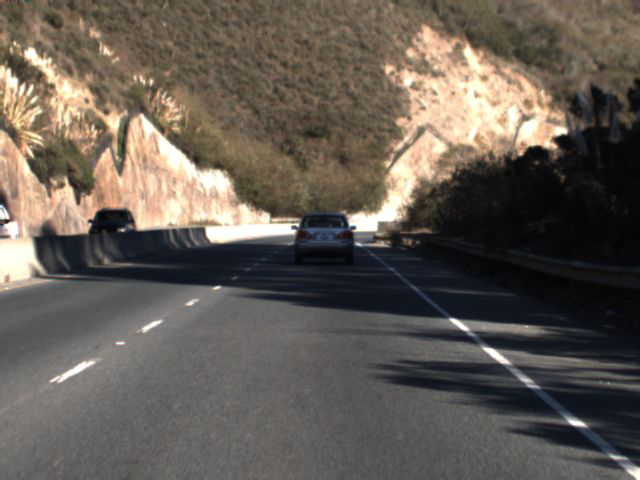

In [10]:
from PIL import Image
from io import BytesIO

res = fin.flatMap(
    partial(msg_map, func=lambda r: r.data, conn=conn_d['/center_camera/image_color/compressed'])
).take(50)
 
Image.open(BytesIO(res[48]))

### Plot fuel level
The topic /vehicle/fuel_level_report contains 2215 ROS messages. Let us plot the header.stamp in seconds vs. fuel_level using a pandas dataframe

<IPython.core.display.Javascript object>


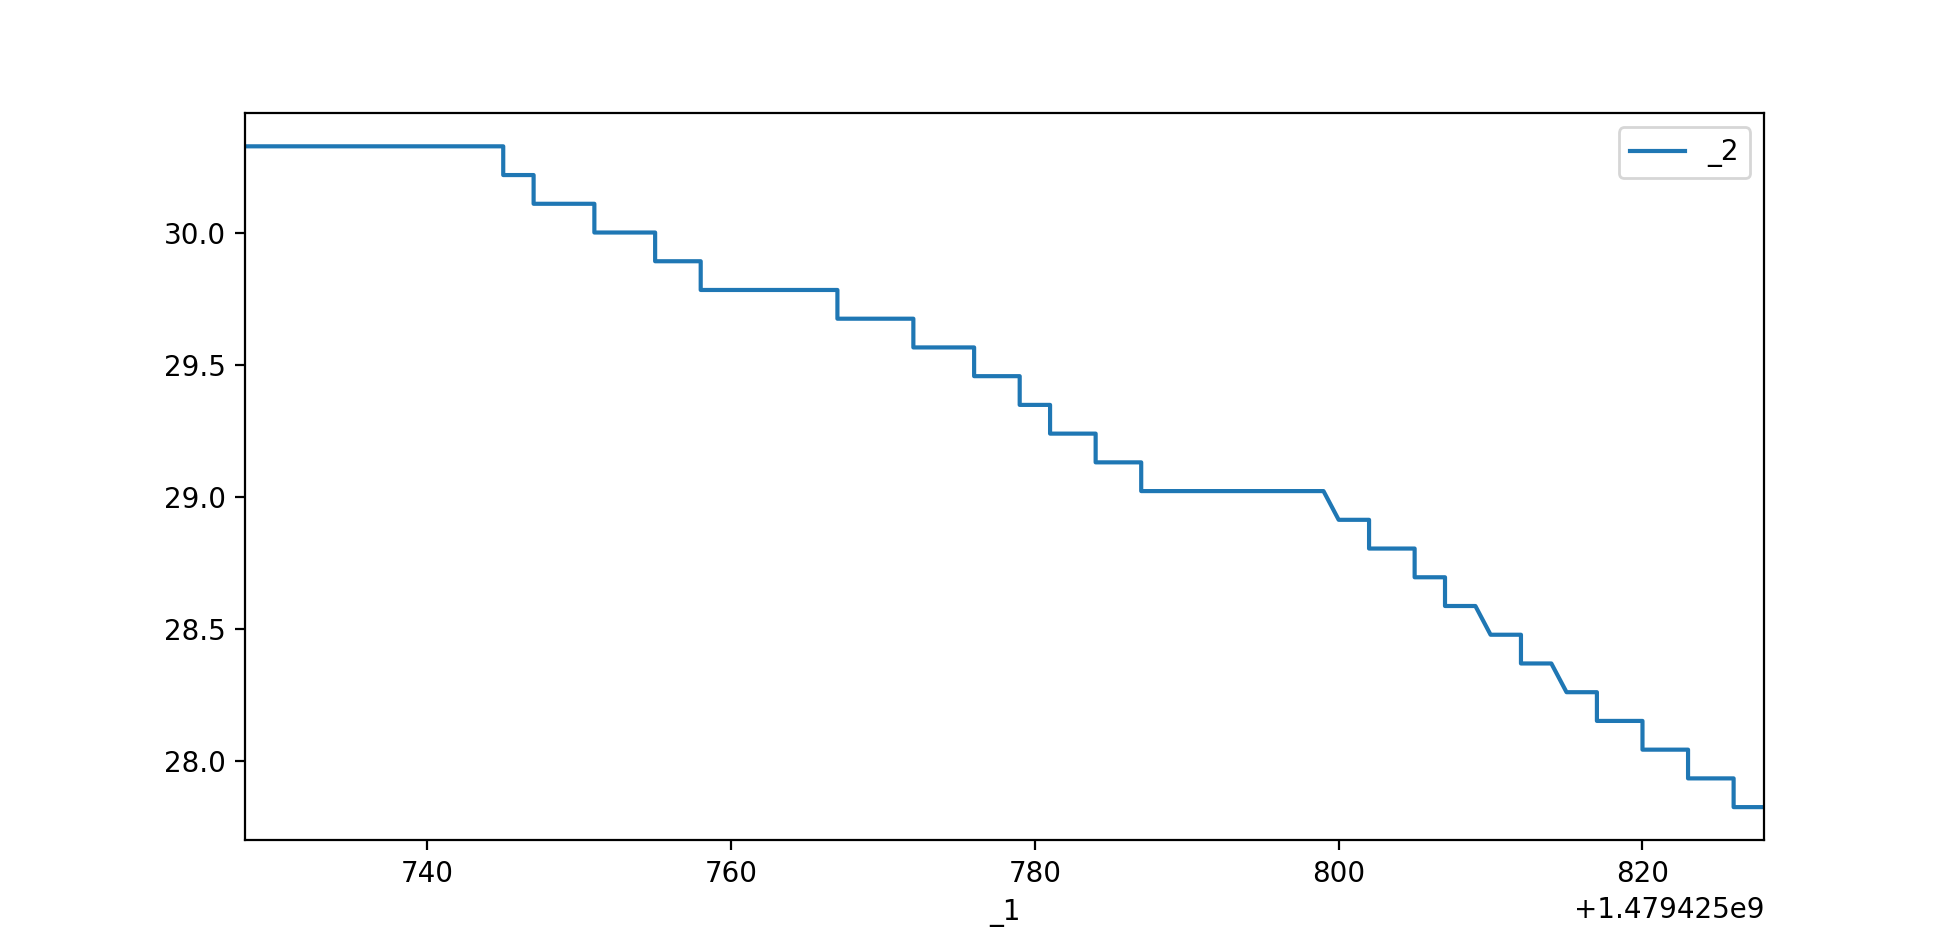

In [11]:
def f(msg):
    return (msg.header.stamp.secs, msg.fuel_level)

d = fin.flatMap(
    partial(msg_map, func=f, conn=conn_d['/vehicle/fuel_level_report'])
).toDF().toPandas()

d.set_index('_1').plot()

### Machine Learning models on Spark workers
A dot product Keras "model" for each message from a topic. We will compare it with the one computed with numpy.

**Note** that the imports happen in the workers and not in driver. On the other hand the connection dictionary is sent over the closure.

In [12]:
def f(msg):
    from keras.layers import dot, Dot, Input
    from keras.models import Model
    
    linear_acceleration = {
        'x': msg.linear_acceleration.x,
        'y': msg.linear_acceleration.y,
        'z': msg.linear_acceleration.z,
    }
    
    linear_acceleration_covariance = np.array(msg.linear_acceleration_covariance)
    
    i1 = Input(shape=(3,))
    i2 = Input(shape=(3,))
    o = dot([i1,i2], axes=1)
    
    model = Model([i1,i2], o)
    
    # return a tuple with (numpy dot product, keras dot "predict")
    return (
        np.dot(linear_acceleration_covariance.reshape(3,3), 
               [linear_acceleration['x'], linear_acceleration['y'], linear_acceleration['z']]),
        model.predict([
            np.array([[ linear_acceleration['x'], linear_acceleration['y'], linear_acceleration['z'] ]]),
            linear_acceleration_covariance.reshape((3,3))])
    )

fin.flatMap(partial(msg_map, func=f, conn=conn_d['/vehicle/imu/data_raw'])).take(5)

# tuple with (numpy dot product, keras dot "predict")

[(array([-0.07,  0.  ,  0.  ]), array([[-0.07]], dtype=float32)),
 (array([-0.06,  0.  ,  0.  ]), array([[-0.06]], dtype=float32)),
 (array([-0.04,  0.  ,  0.  ]), array([[-0.04]], dtype=float32)),
 (array([-0.05,  0.  ,  0.  ]), array([[-0.05]], dtype=float32)),
 (array([-0.09,  0.  ,  0.  ]), array([[-0.09]], dtype=float32))]

One can of course sample and collect the data in the driver to train a model.

Note that the msg is the most granular unit but you could of course replace the flatMap with a **mapPartitions**

Another option would be to have a map.reduceByKey before the flatMap so that the function argument would be a whole interval instead of a msg.